# Hyperview

## Updates:
* dividing by max value, so all values are (0, 1)
* sigmoid as final activation in modeller, then mu and std are multiplied by 150 in renderer
* shift instead of intensity (adding constant instead of multiplying)
* verification of spectral curves for each pixel

Result: the predicted spectral curve seems to be averaged target curve

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.dataset import HyperviewDataset

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

## Dataset
Ignoring image masks for now, using regular images and cropping them.

In [3]:
SIZE = 30
max_val = 5500

In [4]:
dataset = HyperviewDataset("data/hyperview/train_data/train_data", SIZE, max_val)

In [5]:
len(dataset)

1732

In [40]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [1400, 200, 132])

In [41]:
trainloader = DataLoader(train_set, batch_size=8, shuffle=True)
valloader = DataLoader(val_set, batch_size=8)
testloader = DataLoader(test_set, batch_size=8)

## Architectures

### Modeller
Output shaped N x K x 3 x H x W, K-number of triples (mu, std, shift) describing distributions.

In [91]:
class Modeller(nn.Module):
    def __init__(self, channels: int = 150, k: int = 10, size: int = 40):
        super(Modeller, self).__init__()
        self.k = k
        self.size = size
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 3 * self.k, kernel_size=1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x)) # multiply mu and sigma by 150 in renderer
        x = x.view(x.shape[0], self.k, 3, self.size, self.size)
        return x

### Renderer

In [139]:
class Renderer:
    def __init__(self) -> None:
        pass

    def __call__(self, batch: Tensor) -> Tensor:
        batch_size, k, params, h, w = batch.shape
        self.bands = torch.arange(150).float().repeat(k, h, w, 1).to(DEVICE)
        rendered = torch.zeros((batch_size, 150, h, w))

        for idx in range(batch_size):
            dists = self.generate_distribution(
                batch[idx, :, 0, ...], batch[idx, :, 1, ...], batch[idx, :, 2, ...]
            )
            pixel_dist = torch.sum(dists, dim=0)
            rendered[idx] = pixel_dist.permute(2, 0, 1)

        return rendered.to(DEVICE)

    def generate_distribution(self, mu: Tensor, std: Tensor, shift: Tensor):
        eps = 1e-4
        std = torch.add(std, eps)
        normal_dist = Normal(150 * mu.unsqueeze(-1), 150 * std.unsqueeze(-1))
        return torch.exp(normal_dist.log_prob(self.bands)) + shift.unsqueeze(-1) * 0.25

#### Example of rendering

In [140]:
# two example hats
hat1 = [0.5, 0.1, 0]
hat2 = [ 0.7, 0.01, 1]

In [141]:
# reshaping to input compatible with renderer
t = Tensor([[hat1, hat2]]).unsqueeze(-1).unsqueeze(-1).to(DEVICE)
renderer = Renderer()
rendered = renderer(t)

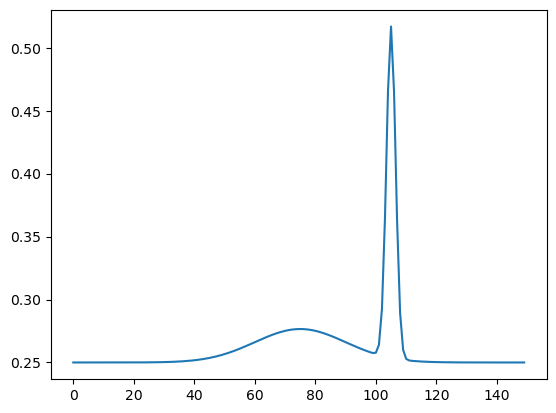

In [142]:
# two hats combined
plt.plot(rendered[0][:,0,0].cpu())

## Training

In [143]:
def train(
    model: nn.Module,
    trainloader: DataLoader,
    valloader: DataLoader,
    num_epochs: int,
    device: str,
    lr: float,
) -> tuple[nn.Module, list[float], list[float]]:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    renderer = Renderer()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        step_losses = []
        with tqdm(trainloader, unit="batch") as tepoch:
            for input in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                optimizer.zero_grad()
                input = input.to(device)
                y_pred = model(input)
                y_pred_r = renderer(y_pred)
                loss = criterion(y_pred_r, input)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                step_losses.append(loss.cpu().detach().numpy())
        train_losses.append(np.mean(step_losses))
        model.eval()
        running_vloss = 0.0
        with torch.no_grad():
            for i, vdata in enumerate(valloader):
                vinputs= vdata.to(device)
                voutputs = model(vinputs)
                voutputs_r = renderer(voutputs)
                vloss = torch.sqrt(criterion(voutputs_r, vinputs))
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        val_losses.append(avg_vloss.cpu())
        scheduler.step()
    return model, train_losses, val_losses

In [144]:
model = Modeller(k=5, size=SIZE).to(DEVICE)
model, tloss, vloss = train(model, trainloader, valloader, 30, DEVICE, 1e-5)

Epoch 29: 100%|██████████| 175/175 [00:02<00:00, 71.24batch/s, loss=0.146] 


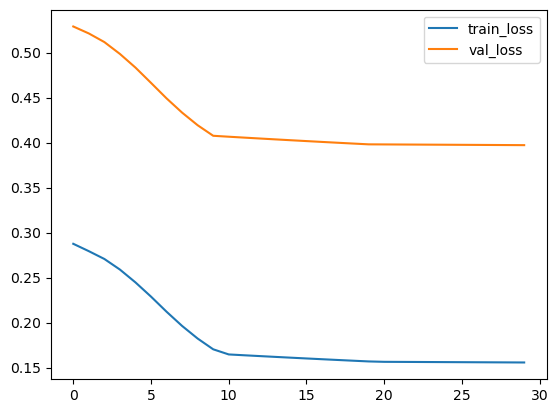

In [145]:
plt.plot(tloss, label="train_loss")
plt.plot(vloss, label="val_loss")
plt.legend()
plt.show()

## Results

In [154]:
renderer = Renderer()
imgs = []
outputs = []
for img in testloader:
    out = model(img.to(DEVICE))
    rendered = renderer(out)
    imgs.append(img)
    outputs.append(rendered)

In [158]:
gt_img = imgs[0][1]
pred_img = outputs[0][1].cpu().detach().numpy()

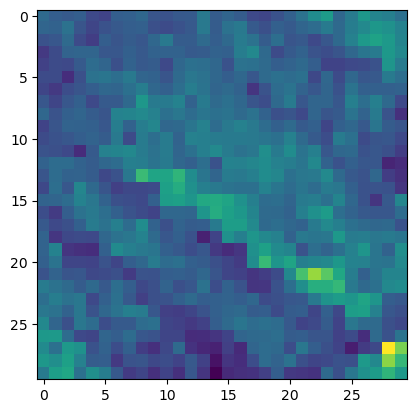

In [156]:
# original image - band0
plt.imshow(gt_img[0])

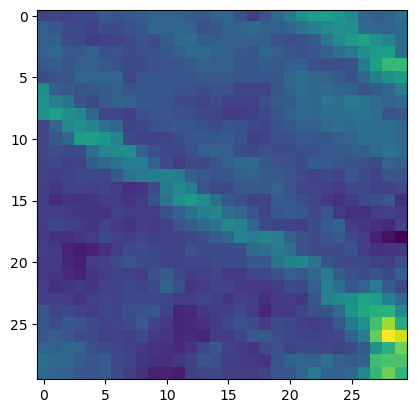

In [159]:
# reconstructed image - band0
plt.imshow(pred_img[0])

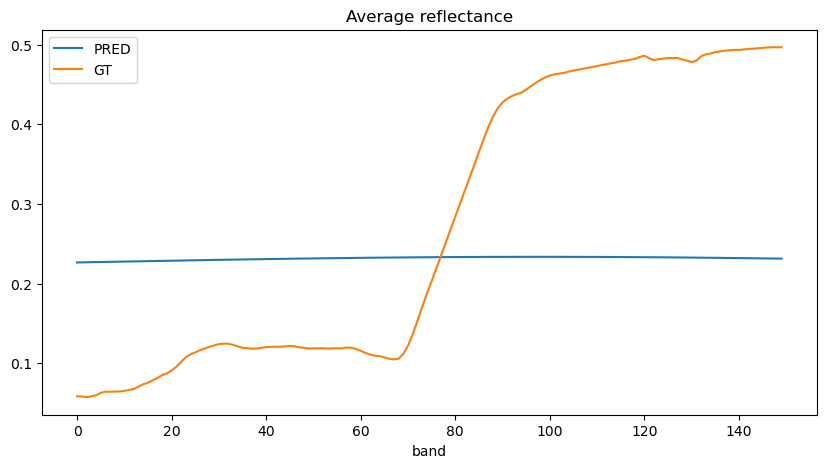

In [160]:
fig = plt.figure(figsize=(10, 5))

gt_mean_spectral_reflectance = [gt_img[i].mean() for i in range(gt_img.shape[0])]
pred_mean_spectral_reflectance = [pred_img[i].mean() for i in range(pred_img.shape[0])]

plt.plot(pred_mean_spectral_reflectance, label="PRED")
plt.plot(gt_mean_spectral_reflectance, label="GT")

plt.xlabel("band")
plt.legend()
plt.title("Average reflectance")
plt.show()

Seems like predictions are averaging GT.

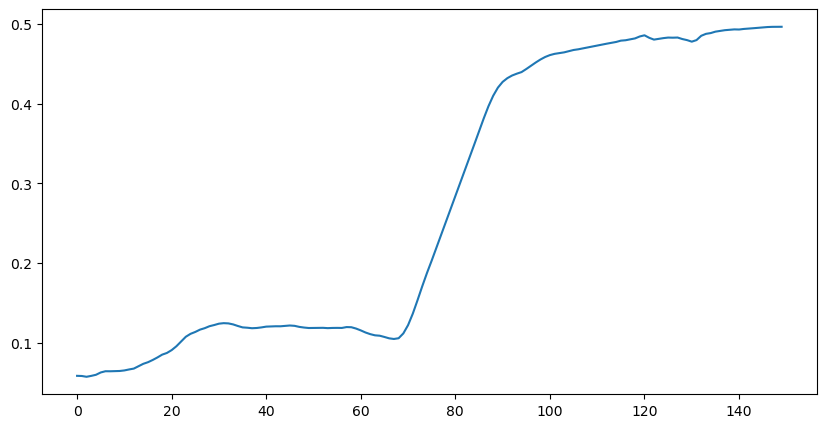

In [161]:
fig = plt.figure(figsize=(10, 5))
plt.plot(gt_mean_spectral_reflectance, label="GT")
plt.show()

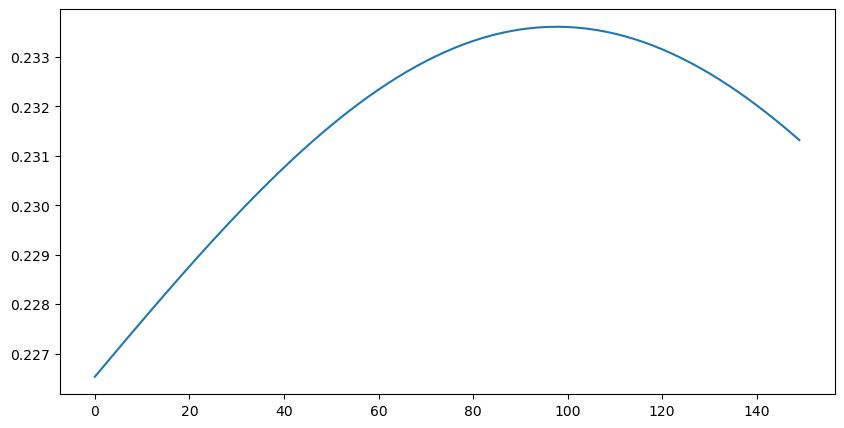

In [162]:
fig = plt.figure(figsize=(10, 5))
plt.plot(pred_mean_spectral_reflectance, label="PRED")
plt.show()

### Spectral curves for every pixel

In [163]:
fig, axs = plt.subplots(SIZE, SIZE, figsize=(100, 150))

for i in range(SIZE):
    for j in range(SIZE):
        axs[i,j].plot(pred_img[:,i,j])
        axs[i,j].plot(gt_img[:,i,j])
plt.savefig("spectral_curves.png")